In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
import zipfile
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/Users/jejunhpark/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Import Datasets

In [2]:
# http get requests / parse it into beautifulsoup

# requests.adapters.DEFAULT_RETRIES = 5
# increase retries number
# s = requests.session()
# s.keep_alive = False
s = requests.get("https://usda.library.cornell.edu/concern/publications/rn301137d?locale=en")
html = s.text
soup = BeautifulSoup(html, 'html.parser')

In [3]:
#release-items > tr:nth-child(1) > td.file_set > div > a:nth-child(3)
files = soup.select(
    'tr > td > div > a'
)

In [4]:
# grab all the download urls
all_zip_urls = []
for file in files:
    if 'zip' in file.get('href'):
        all_zip_urls.append(file.get('href'))
        
# remove redundant data: data recorded in 2022 is in both release and the lastest release section
all_zip_urls = all_zip_urls[:-1]
        
all_zip_urls.sort(key = lambda x: x.split(".")[-2][-2:])

In [5]:
# extract data file name from the original data name
dir_names = []

for file_name in all_zip_urls:
    
    year = file_name.split('/')[-1].split(".")[0][-4:]
        
    if year.startswith("0"):
        file_name = "20" + year[-2:]
        dir_names.append(file_name)
    else:
        file_name = year
        dir_names.append(file_name)
        
dir_names.sort()

In [6]:
# download each zip file into each data directory
# create a directory that will contain all raw dataset
os.mkdir('dataset')

for idx in range(len(all_zip_urls)):
    
    # sending the request to download zip files
    r = requests.get(all_zip_urls[idx])
    
    # download each zip file into corresponding directory
    name = os.path.join('dataset', dir_names[idx])
    
    # if the directory does not exist, create one
    if not os.path.exists(name):
        os.mkdir(name)
        
    # download each zip file with the name of the year
    file_name = os.path.join('dataset', dir_names[idx], dir_names[idx])
    
    # writing bytes file - for zip files, you have to use 'wb'
    # notice type(r.content) is bytes, not string
    with open(file_name, 'wb') as f:
        f.write(r.content)

FileExistsError: [Errno 17] File exists: 'dataset'

In [ ]:
# extract all zip files
for idx in range(len(dir_names)):
    zpath = os.path.join('dataset', dir_names[idx], dir_names[idx]) 
    
    with zipfile.ZipFile(zpath, 'r') as z:
        z.extractall(os.path.join('dataset', dir_names[idx]))

z.close()

## Preprocessing

### 1) Colony Dataset

In [ ]:
def clean_colony(path):
    # read and clean the data
    col_labels = ['states', 'colony_n', 'colony_max', 'colony_lost', 'colony_lost_pct', 'colony_added', 'colony_reno', 'colony_reno_pct']
    
    # temporarily read the csv file and extract month and year of the current dataset
    temp_df = pd.read_csv(path, encoding = 'Latin 1', engine = 'python', na_values = "(Z)", nrows = 1, header = 1)
    month_year = list(set(re.findall(r"\d{4}|[\w]+-[\w]+", temp_df.columns[2])))
    month_year.sort(key = lambda x: len(x))
    year = int(month_year[0])
    month = month_year[1]

    # read the given dataset skipping certain rows and columns to get the actual data
    # put year and month columns
    df = pd.read_csv(path, encoding = 'Latin 1', skiprows = 8, skipfooter = 11, engine = 'python', usecols = list(range(2, 10)), header =  0, names = col_labels, na_values = ['(Z)', '(NA)'])
    df['year'] = year
    df['month'] = month
    df = df[df.columns[-2:].tolist() + df.columns[:-2].tolist()]
    
    # remove rows in which state value is null
    # this indicates that the whole row consists of null
    s = df.states.isnull()
    index_to_drop = s.where(s==True).dropna().index
    df = df.drop(index_to_drop)
    
    # from the dataset description, '-' indicates 0
    df = df.replace("-", 0)
    
    # filter out all the values that are not appropriate states names, including 'Other States.'
    states = df.states.str.findall(r'[A-Za-z]+ [A-Za-z]+|[A-Za-z]+').apply(lambda x:x[0])
    df.states = states
    
    # Lastly, convert data type of each column correspondingly
    df = df.astype({"year": str, "colony_n": float, "colony_max": float, "colony_lost": float, "colony_lost_pct": float, "colony_added": float, "colony_reno": float, "colony_reno_pct": float})
    
    return df

In [ ]:
# initialize a list to contain all data paths
whole_path = []
year_path = [os.path.join('dataset', file) for file in dir_names]

# for each year directory, only read files that contain colony data
# order the files so that all of them are in order of time
for cur_year in year_path:
    cur_list = os.listdir(cur_year)
    temp_list = []
    
    for file in cur_list:
        match = re.search(r"t005|t001|t007|t008|t011|t022", file)
    
        if match:
            temp_list.append(os.path.join(cur_year, file))
            

    temp_list.sort(key = lambda x: x.split("_")[1])
    whole_path = whole_path + temp_list
    
# combine those colony datasets into one
colony = pd.concat(map(clean_colony, whole_path))

# set the index number correctly
idx = list(range(len(colony)))
colony.index = idx

In [ ]:
colony.head()

In [ ]:
colony.isnull().sum()

In [ ]:
colony.dtypes

In [ ]:
colony.to_csv('colony.csv', index=False)

### 2) Stressor Dataset

Import stressor datasets by repeating the process of importing colony datasets.

In [ ]:
def clean_stressor(path):
    # read and clean the data
    col_labels = ['states', 'Varroa Mites', 'Other pests/parasites', 'Diseases', 'Pesticides', 'Other', 'Unknown']
    
    # temporarily read the csv file and extract month and year of the current dataset
    temp_df = pd.read_csv(path, encoding = 'Latin 1', engine = 'python', na_values = "(Z)", nrows = 1, header = 1)
    month_year = list(set(re.findall(r"\d{4}|[\w]+-[\w]+", temp_df.columns[2])))
    month_year.sort(key = lambda x: len(x))
    year = month_year[0]
    month = month_year[1]

    # read the given dataset skipping certain rows and columns to get the actual data
    # put year and month columns
    df = pd.read_csv(path, encoding = 'Latin 1', skiprows = 8, skipfooter = 8, usecols = list(range(2, 9)), engine = 'python', na_values = ['(Z)', '(NA)'], names = col_labels)
    df['year'] = year
    df['month'] = month
    df = df[df.columns[-2:].tolist() + df.columns[:-2].tolist()]
    
    # remove rows in which state value is null
    # this indicates that the whole row consists of null
    s = df.states.isnull()
    index_to_drop = s.where(s==True).dropna().index
    df = df.drop(index_to_drop)
    
    # from the dataset description, '-' indicates 0
    df = df.replace("-", 0)
    
    # pivot the table: from wide to long
    df = pd.melt(df, id_vars = ['year', 'month', 'states'], value_vars = ['Varroa Mites', 'Other pests/parasites', 'Diseases', 'Pesticides', 'Other', 'Unknown'], var_name = 'stressor', value_name = 'stress_pct').sort_values(by = 'states')
    
    # filter out all the values that are not appropriate states names, including 'Other States.'
    states = df.states.str.findall(r'[A-Za-z]+ [A-Za-z]+|[A-Za-z]+').apply(lambda x:x[0])
    df.states = states
    
    
    # Lastly, convert data type of each column correspondingly
    df = df.astype({'year': str, 'month': str, 'states': str, 'stressor': str, 'stress_pct': float})
    
    return df

In [ ]:
# initialize a list to contain all data paths
whole_path = []
year_path = [os.path.join('dataset', file) for file in dir_names]

# for each year directory, only read files that contain colony data
# order the files so that all of them are in order of time
for cur_year in year_path:
    cur_list = os.listdir(cur_year)
    temp_list = []
    
    for file in cur_list:
        match = re.search(r"t002|t013|t009|t010|t012|t023", file)
    
        if match:
            temp_list.append(os.path.join(cur_year, file))
            

    temp_list.sort(key = lambda x: x.split("_")[1])
    whole_path = whole_path + temp_list
    

# combine those colony datasets into one
stressor = pd.concat(map(clean_stressor, whole_path))

# set the index number correctly
idx = list(range(len(stressor)))
stressor.index = idx

In [ ]:
stressor.head()

In [ ]:
stressor.isnull().sum()

In [ ]:
stressor.dtypes

In [ ]:
stressor.to_csv("stressor.csv", index=False)

## EDA

In [134]:
colony = pd.read_csv("colony.csv")
stressor = pd.read_csv("stressor.csv")

In [121]:
stressor.head(10)

,year,month,states,stressor,stress_pct
0,2015,January-March,Alabama,Varroa Mites,10.0
1,2015,January-March,Alabama,Diseases,NaN
2,2015,January-March,Alabama,Unknown,9.4
3,2015,January-March,Alabama,Other,9.1
4,2015,January-March,Alabama,Pesticides,2.2
5,2015,January-March,Alabama,Other pests/parasites,5.4
6,2015,January-March,Arizona,Varroa Mites,26.9
7,2015,January-March,Arizona,Diseases,0.1
8,2015,January-March,Arizona,Unknown,3.1
9,2015,January-March,Arizona,Other pests/parasites,20.5


In [122]:
colony.month.value_counts()

January-March       644
April-June          541
October-December    322
July-September      315
Name: month, dtype: int64

### What is the colony loss percentage per year?

In [135]:
month_mapping = {"January-March":"winter", "April-June":"summer", "July-September":"summer", "October-December":"winter"}
season = colony["month"].map(month_mapping)
colony.insert(3, "season", season)
colony = colony.drop("month", axis=1)

In [136]:
by_year_season = colony[["colony_lost_pct", "year", "season"]].groupby(["season", "year"], as_index=False).mean()
annual = by_year_season[["year", "colony_lost_pct"]].groupby("year", as_index=False).mean()
annual.insert(0, "season", "annual")
by_year_season = pd.concat([by_year_season, annual], ignore_index=True)

In [125]:
by_year_season.tail()

,season,year,colony_lost_pct
19,annual,2018,12.328214
20,annual,2019,11.650327
21,annual,2020,9.917581
22,annual,2021,10.328139
23,annual,2022,9.244444


In [16]:
by_year = by_year_season[by_year_season['season'] == 'annual']
by_year

,season,year,colony_lost_pct
16,annual,2015,12.076570
17,annual,2016,11.437198
18,annual,2017,11.365531
19,annual,2018,12.328214
20,annual,2019,11.650327
21,annual,2020,9.917581
22,annual,2021,10.328139
23,annual,2022,9.244444


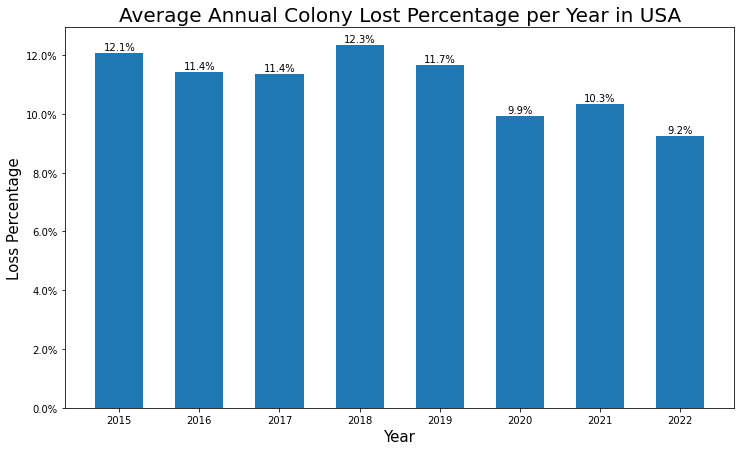

In [17]:
# creating a bar graph with appropriate labels and the title
fig, ax = plt.subplots(1, 1, figsize=(12,7))
b1 = ax.bar(by_year['year'], by_year['colony_lost_pct'], width=0.6)
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Loss Percentage", fontsize=15)
ax.set_title("Average Annual Colony Lost Percentage per Year in USA", fontsize=20)

# change the y tick labels
yvals = ax.get_yticks()
ax.set_yticklabels([str(y) + "%" for y in yvals])

# label each bar
for bar in b1:
    height = bar.get_height()
    ax.annotate(f'{str(round(height, 1)) + "%"}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center')
plt.show()

### What is the colony loss percentage per season?

In [18]:
by_year_season.head(10)

,season,year,colony_lost_pct
0,summer,2015,10.044444
1,summer,2016,9.888889
2,summer,2017,8.577778
3,summer,2018,9.274074
4,summer,2019,10.888889
5,summer,2020,9.291045
6,summer,2021,8.626866
7,summer,2022,7.911111
8,winter,2015,14.108696
9,winter,2016,12.985507


In [19]:
seasons = ['summer', 'winter', 'annual']

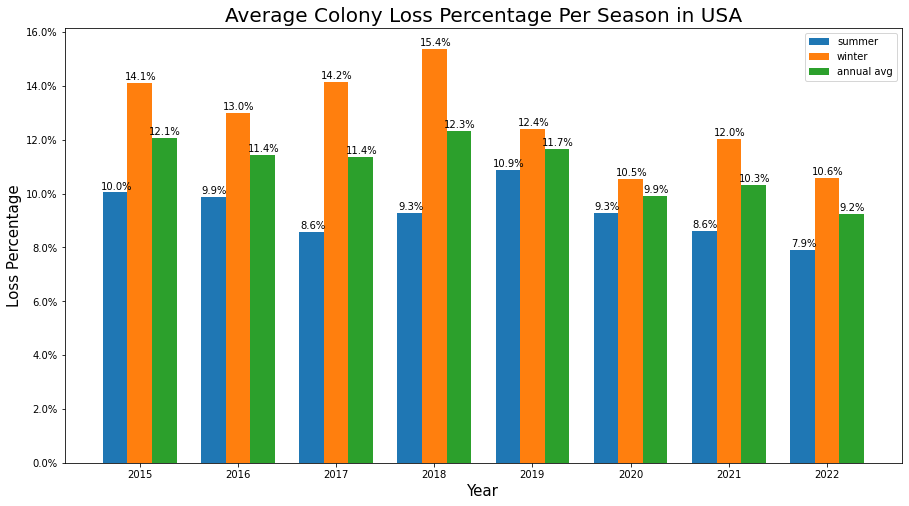

In [20]:
# create figure
fig, ax = plt.subplots(figsize=(15,8))

x = by_year['year']
width = 0.25

summer_bar = ax.bar(x - width, by_year_season[by_year_season['season'] == 'summer']['colony_lost_pct'], width, label='summer')
winter_bar = ax.bar(x, by_year_season[by_year_season['season'] == 'winter']['colony_lost_pct'], width, label='winter')
annual_bar = ax.bar(x + width, by_year_season[by_year_season['season'] == 'annual']['colony_lost_pct'], width, label='annual avg')

# add appropriate title and labels
ax.set_title("Average Colony Loss Percentage Per Season in USA", fontsize=20)
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Loss Percentage", fontsize=15)


# add percentage sign to the y tick label
ax.set_yticklabels([str(l)+"%" for l in ax.get_yticks()])

# add legend
ax.legend()

# annotate each bar
bars = [summer_bar, winter_bar, annual_bar]
for bar in bars:
    for b in bar:
        height = b.get_height()
        ax.annotate(f'{str(round(height, 1)) + "%"}',
                    xy=(b.get_x() + b.get_width() / 2, height),
                    xytext=(1, 3),
                    textcoords="offset points",
                    ha='center')
plt.show()

### What is the loss percentage per regions?

Is there any regions that has significantly higher colony loss?

In [126]:
# from https://gist.github.com/sfirrin/fd01d87f022d80e98c37a045c14109fe
states_to_regions = {
    'Washington': 'West', 'Oregon': 'West', 'California': 'West', 'Nevada': 'West',
    'Idaho': 'West', 'Montana': 'West', 'Wyoming': 'West', 'Utah': 'West',
    'Colorado': 'West', 'Alaska': 'West', 'Hawaii': 'West', 'Maine': 'Northeast',
    'Vermont': 'Northeast', 'New York': 'Northeast', 'New Hampshire': 'Northeast',
    'Massachusetts': 'Northeast', 'Rhode Island': 'Northeast', 'Connecticut': 'Northeast',
    'New Jersey': 'Northeast', 'Pennsylvania': 'Northeast', 'North Dakota': 'Midwest',
    'South Dakota': 'Midwest', 'Nebraska': 'Midwest', 'Kansas': 'Midwest',
    'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest', 'Wisconsin': 'Midwest',
    'Illinois': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Ohio': 'Midwest',
    'West Virginia': 'South', 'District of Columbia': 'South', 'Maryland': 'South',
    'Virginia': 'South', 'Kentucky': 'South', 'Tennessee': 'South', 'North Carolina': 'South',
    'Mississippi': 'South', 'Arkansas': 'South', 'Louisiana': 'South', 'Alabama': 'South',
    'Georgia': 'South', 'South Carolina': 'South', 'Florida': 'South', 'Delaware': 'South',
    'Arizona': 'Southwest', 'New Mexico': 'Southwest', 'Oklahoma': 'Southwest',
    'Texas': 'Southwest', 'Other States': 'other'}

In [137]:
colony_region = colony.states.map(states_to_regions)
colony.insert(3, 'region', colony_region)

In [23]:
per_region = colony[['region', 'colony_lost_pct']].groupby('region', as_index=False).mean()
per_region

,region,colony_lost_pct
0,Midwest,11.630108
1,Northeast,9.044280
2,South,12.790927
3,Southwest,13.771242
4,West,8.846821
5,other,13.363636


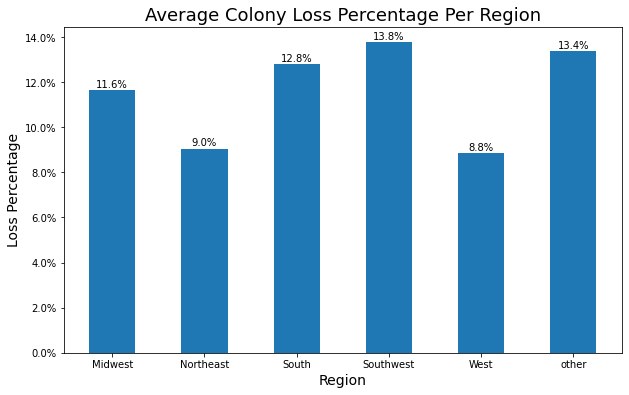

In [24]:
# create a bar plot
fig, ax = plt.subplots(figsize=(10,6))
b = ax.bar(per_region['region'], per_region['colony_lost_pct'], width=0.5)

# add labels
ax.set_title("Average Colony Loss Percentage Per Region", fontsize=18)
ax.set_ylabel("Loss Percentage", fontsize=14)
ax.set_xlabel("Region", fontsize=14)

# edit y tick labels
ax.set_yticklabels([str(l)+"%" for l in ax.get_yticks()])

#label each bar
for bar in b:
    height = bar.get_height()
    ax.annotate(f'{str(round(height, 1)) + "%"}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center')

plt.show()

### Do the states that suffered higher colony loss tend to add and renovate more colonies?

In [25]:
# correlation between loss and addition of colonies
df = colony[['colony_lost', 'colony_added']]
df.head()

,colony_lost,colony_added
0,1800.0,2800.0
1,4600.0,3400.0
2,1500.0,1200.0
3,255000.0,250000.0
4,1500.0,200.0


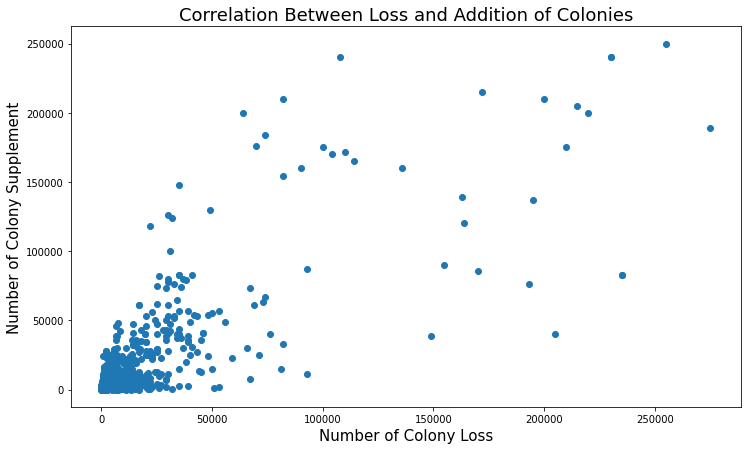

In [26]:
# create a scatter plot
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(df['colony_lost'], df['colony_added'])

# add appropriate labels
ax.set_title("Correlation Between Loss and Addition of Colonies", fontsize=18)
ax.set_xlabel("Number of Colony Loss", fontsize=15)
ax.set_ylabel("Number of Colony Supplement", fontsize=15)

plt.show()

In [27]:
df.corr()

,colony_lost,colony_added
colony_lost,1.000000,0.810559
colony_added,0.810559,1.000000


In [28]:
# correlation between loss and renevation of colonies
df = colony[['colony_lost', 'colony_reno']]
df.head()

,colony_lost,colony_reno
0,1800.0,250.0
1,4600.0,2100.0
2,1500.0,90.0
3,255000.0,124000.0
4,1500.0,140.0


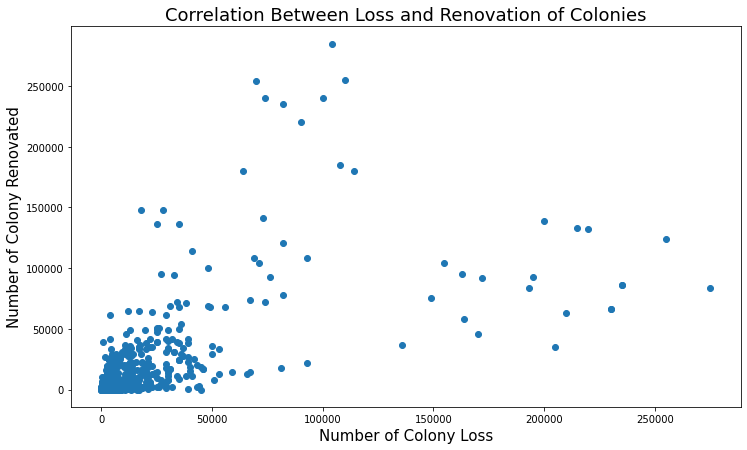

In [29]:
# create a scatter plot
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(df['colony_lost'], df['colony_reno'])

# add appropriate labels
ax.set_title("Correlation Between Loss and Renovation of Colonies", fontsize=18)
ax.set_xlabel("Number of Colony Loss", fontsize=15)
ax.set_ylabel("Number of Colony Renovated", fontsize=15)

plt.show()

In [30]:
df.corr()

,colony_lost,colony_reno
colony_lost,1.000000,0.659655
colony_reno,0.659655,1.000000


States tend to add more colonies rather than renovate them. The correlation between `colony_lost` and `colony_add` is much higher than that of `colony_lost` and `colony_reno`.

## Stressor

In [140]:
# create season columns using month column
stressor_season = stressor['month'].map(month_mapping)
stressor.insert(2, 'season', stressor_season)
stressor.drop('month', axis=1, inplace=True)

In [141]:
# create region column using states column - using states_to_regions dictionary defined above
stressor_regions = stressor['states'].map(states_to_regions)
stressor.insert(3, 'region', stressor_regions)

In [130]:
stressor.head(10)

,year,season,states,region,stressor,stress_pct
0,2015,winter,Alabama,South,Varroa Mites,10.0
1,2015,winter,Alabama,South,Diseases,NaN
2,2015,winter,Alabama,South,Unknown,9.4
3,2015,winter,Alabama,South,Other,9.1
4,2015,winter,Alabama,South,Pesticides,2.2
5,2015,winter,Alabama,South,Other pests/parasites,5.4
6,2015,winter,Arizona,Southwest,Varroa Mites,26.9
7,2015,winter,Arizona,Southwest,Diseases,0.1
8,2015,winter,Arizona,Southwest,Unknown,3.1
9,2015,winter,Arizona,Southwest,Other pests/parasites,20.5


### What is the distribution of stressors percentage per season?

In [34]:
stressor_by_season = stressor[['season', 'stressor', 'stress_pct']].groupby(['season', 'stressor'], as_index=False).mean('stress_pct')
stressor_by_season

,season,stressor,stress_pct
0,summer,Diseases,4.237500
1,summer,Other,6.810123
2,summer,Other pests/parasites,12.623434
3,summer,Pesticides,7.686340
4,summer,Unknown,3.698062
5,summer,Varroa Mites,32.762878
6,winter,Diseases,3.288540
7,winter,Other,5.556082
8,winter,Other pests/parasites,9.236145
9,winter,Pesticides,4.610857


In [35]:
# create to different dataframes: one for summer and the other for winter
summer_df = stressor_by_season[stressor_by_season['season']=='summer']
winter_df = stressor_by_season[stressor_by_season['season']=='winter']

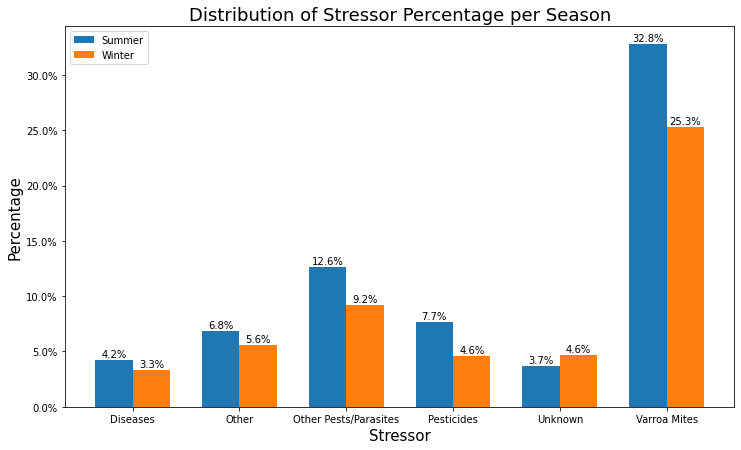

In [38]:
# create plot that contains two bar plots - summer and winter
fig, ax = plt.subplots(figsize=(12,7))
width = 0.35
x = np.arange(len(summer_df['stress_pct']))
labels = ['Diseases', 'Other', 'Other Pests/Parasites', 'Pesticides', 'Unknown', 'Varroa Mites']

# setting grouped bar chart
summer_bar = ax.bar(x-width/2, summer_df['stress_pct'], width, label='Summer')
winter_bar = ax.bar(x+width/2, winter_df['stress_pct'], width, label='Winter')

# set appropriate labels
ax.set_xticks(x, labels)
ax.set_title("Distribution of Stressor Percentage per Season", fontsize=18)
ax.set_xlabel("Stressor", fontsize=15)
ax.set_ylabel("Percentage", fontsize=15)
ax.set_yticklabels([str(l)+"%" for l in ax.get_yticks()])
ax.legend()

# label each bar
for season in [summer_bar, winter_bar]:
    for b in season:
        height = b.get_height()
        ax.annotate(f'{str(round(height, 1)) + "%"}',
                       xy=(b.get_x() + b.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center')

plt.show()

### What is the distribution of stressors percentage for each region?

In [43]:
stressor_by_region = stressor[['region', 'stressor', 'stress_pct']].groupby(['region', 'stressor'], as_index=False).mean('stress_pct')
stressor_by_region.head(10)

,region,stressor,stress_pct
0,Midwest,Diseases,3.628297
1,Midwest,Other,7.570833
2,Midwest,Other pests/parasites,9.906757
3,Midwest,Pesticides,7.792237
4,Midwest,Unknown,4.945495
5,Midwest,Varroa Mites,27.592918
6,Northeast,Diseases,2.654357
7,Northeast,Other,4.178113
8,Northeast,Other pests/parasites,5.185283
9,Northeast,Pesticides,3.706967


In [112]:
stressor['stressor'].unique()

array(['Varroa Mites', 'Diseases', 'Unknown', 'Other', 'Pesticides',
       'Other pests/parasites'], dtype=object)

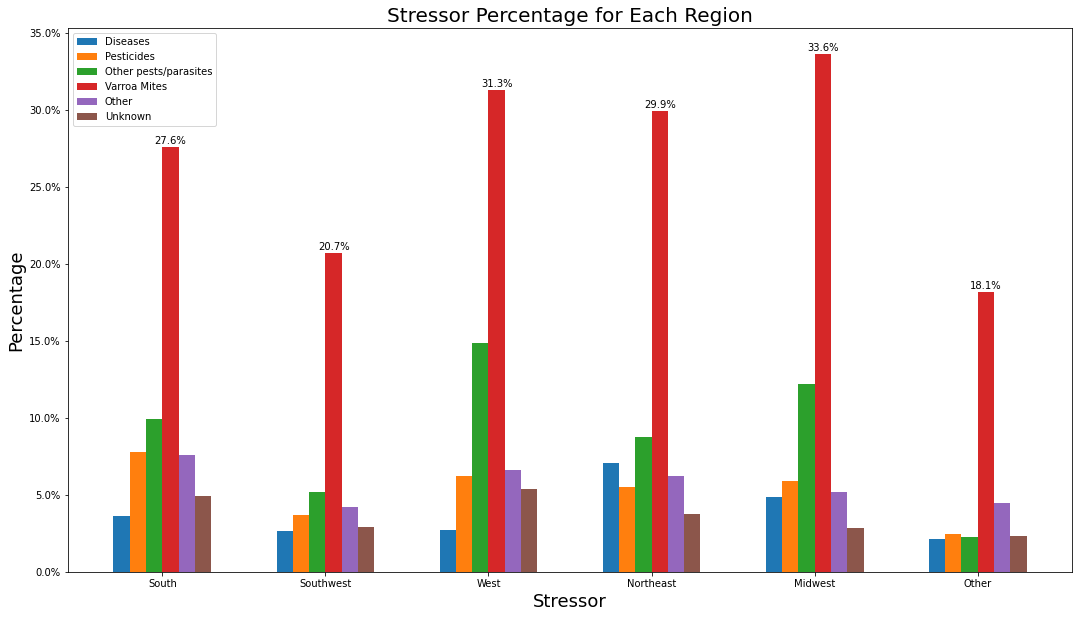

In [117]:
# create and specify bar chart size
fig, ax = plt.subplots(figsize=(18,10))
labels = pd.Series(stressor['region'].unique()).replace({'other':'Other'})
x = np.arange(len(labels))
width = 0.1

# create a grouped bar chart
diseases_bar = ax.bar(x-(width/2)-2*width, stressor_by_region[stressor_by_region['stressor']=='Diseases']['stress_pct'], width, label='Diseases')
pesticides_bar = ax.bar(x-(width/2)-width, stressor_by_region[stressor_by_region['stressor']=='Pesticides']['stress_pct'], width, label='Pesticides')
other_pest_bar = ax.bar(x-(width/2), stressor_by_region[stressor_by_region['stressor']=='Other pests/parasites']['stress_pct'], width, label='Other pests/parasites')
varroa_mite_bar = ax.bar(x+(width/2), stressor_by_region[stressor_by_region['stressor']=='Varroa Mites']['stress_pct'], width, label='Varroa Mites')
other_bar = ax.bar(x+(width/2)+width, stressor_by_region[stressor_by_region['stressor']=='Other']['stress_pct'], width, label='Other')
unknown_bar = ax.bar(x+(width/2)+2*width, stressor_by_region[stressor_by_region['stressor']=='Unknown']['stress_pct'], width, label='Unknown')

# add appropriate labels
ax.set_title('Stressor Percentage for Each Region', fontsize=20)
ax.set_xlabel('Stressor', fontsize=18)
ax.set_ylabel('Percentage', fontsize=18)
ax.legend(loc=2)

# edit tick labels
ax.set_yticklabels([str(l)+'%' for l in ax.get_yticks()])
ax.set_xticks(x, labels)

# only label varroa mite bar
for b in varroa_mite_bar:
    height = b.get_height()
    ax.annotate(f'{str(round(height, 1)) + "%"}',
                       xy=(b.get_x() + b.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center')

plt.show()

In [142]:
stressor

,year,season,states,region,stressor,stress_pct
0,2015,winter,Alabama,South,Varroa Mites,10.0
1,2015,winter,Alabama,South,Diseases,NaN
2,2015,winter,Alabama,South,Unknown,9.4
3,2015,winter,Alabama,South,Other,9.1
4,2015,winter,Alabama,South,Pesticides,2.2
...,...,...,...,...,...,...
11035,2022,summer,Wyoming,West,Other pests/parasites,2.5
11036,2022,summer,Wyoming,West,Other,3.0
11037,2022,summer,Wyoming,West,Diseases,5.1
11038,2022,summer,Wyoming,West,Unknown,1.0


In [139]:
colony

,year,states,season,region,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_reno,colony_reno_pct
0,2015,Alabama,winter,South,7000.0,7000.0,1800.0,26.0,2800.0,250.0,4.0
1,2015,Arizona,winter,Southwest,35000.0,35000.0,4600.0,13.0,3400.0,2100.0,6.0
2,2015,Arkansas,winter,South,13000.0,14000.0,1500.0,11.0,1200.0,90.0,1.0
3,2015,California,winter,West,1440000.0,1690000.0,255000.0,15.0,250000.0,124000.0,7.0
4,2015,Colorado,winter,West,3500.0,12500.0,1500.0,12.0,200.0,140.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1817,2022,Virginia,summer,South,9000.0,10500.0,580.0,6.0,2900.0,680.0,6.0
1818,2022,Washington,summer,West,97000.0,109000.0,6000.0,6.0,12500.0,23000.0,21.0
1819,2022,West Virginia,summer,South,5000.0,7500.0,260.0,3.0,2400.0,2600.0,35.0
1820,2022,Wisconsin,summer,Midwest,52000.0,62000.0,1600.0,3.0,6000.0,1300.0,2.0
